In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import kernel_est_funcs as kef
import conn_inf_funcs as cif
import remove_outliers as ro
import kernel_fit as kf

#plt.style.use('ggplot')
plt.style.use('seaborn')

#sns.set_style('white')

/tmp/ipykernel_9990/2440146249.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Denoising

Following part will get be repeated afterwards, easily using functions in kernel estimation file. It can be removed after modifying of functions there and adding options for choosing different types of noise.

In [2]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]

noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
spikes_noisy = spikes + noise_intra

calcium = np.zeros((N, sim_dur))
calcium_nsp = np.zeros((N, sim_dur))
tau = 100
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]
calcium_nsp[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]


for t in range(1, sim_dur):
    calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]


In [3]:
n = 500
#calciumN = calcium[n, :]
noise_recording = np.random.normal(0,1, (N, sim_dur))
calcium_noisy = calcium + noise_recording

#calciumN_nsp = calcium_nsp[n, :]
#noise = np.random.normal(0,1, sim_dur)
calcium_nsp_noisy = calcium_nsp + noise_recording

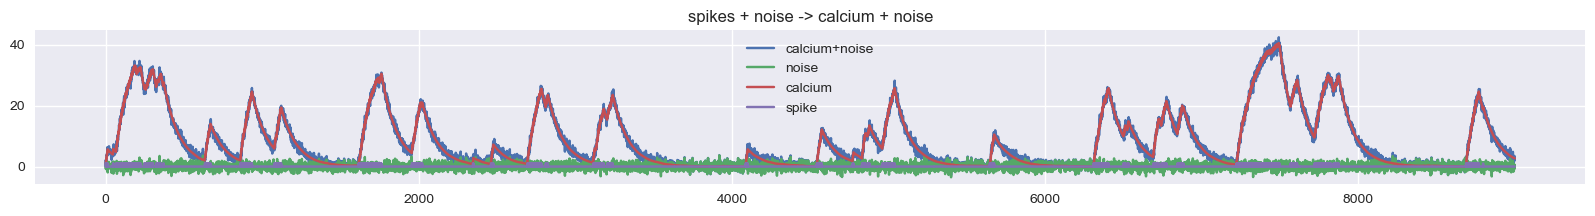

In [4]:
f = plt.figure(figsize=(20,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()


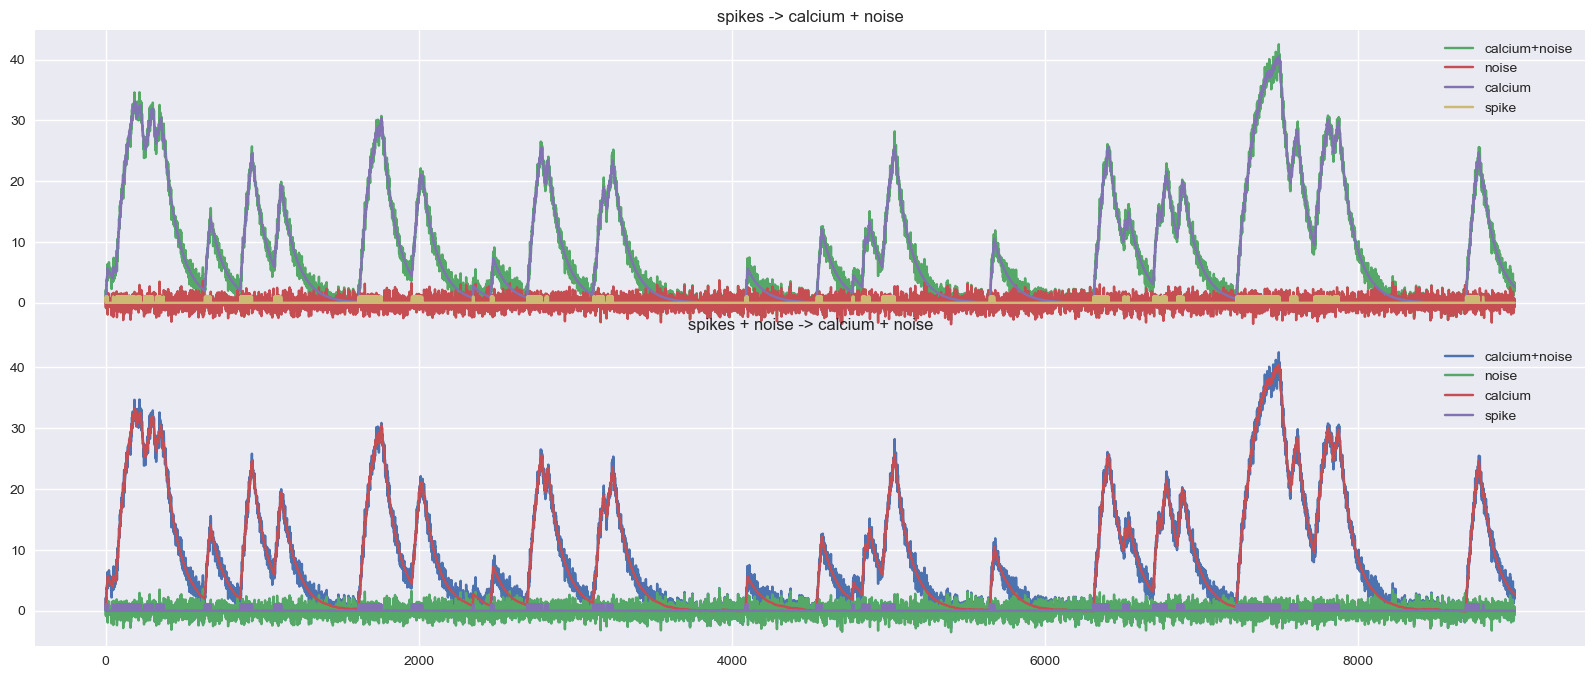

In [5]:
f = plt.figure(figsize=(20,8)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
(ax1, ax2) = f.subplots(2, sharex=True)

ax1.set_title('spikes -> calcium + noise')
ax1.plot(spikes[n, :])
ax1.plot(calcium_noisy[n, :], label = 'calcium+noise')
ax1.plot(noise_recording[n, :], label = 'noise')
ax1.plot(calcium[n, :], label = 'calcium')
ax1.plot(spikes[n, :], label = 'spike')
ax1.legend()

ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

f.subplots_adjust(hspace=0)


Denoising by savitzky filter for signal and its first derivation and putting them into the exact solution of first order eq. works well. this shows sav-gol filter works well in this context. these all are valid when we already know time constant tau in simulation of calcium signals. 

In [6]:
smooth_cal = sig.savgol_filter(calcium_noisy[n, :], window_length=31, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_noisy[n, :], window_length=31, deriv=1, delta=1., polyorder=3)

x_nc = smooth_deriv + (1/tau)*smooth_cal

In [7]:
smooth_cal = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=1, delta=1., polyorder=3)

x_ncsp = smooth_deriv + (1/tau)*smooth_cal

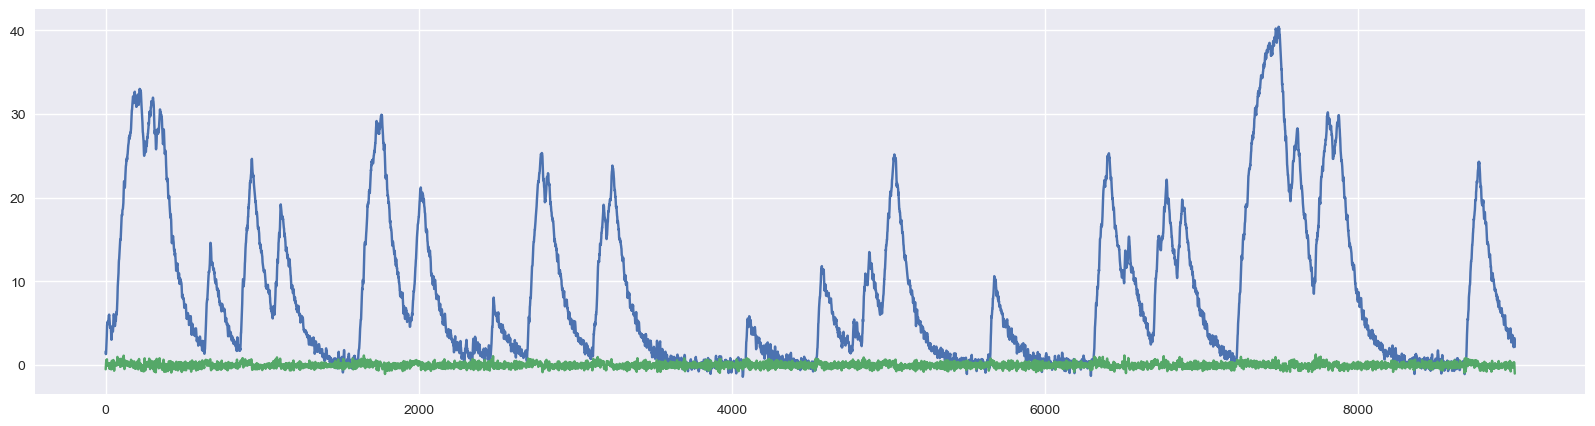

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(smooth_cal)
plt.plot(smooth_deriv)

Recunstruction of signal based on definition of calcium signals in relation of spikes train.

α ẏ(t) + β y(t)  =  x(t)

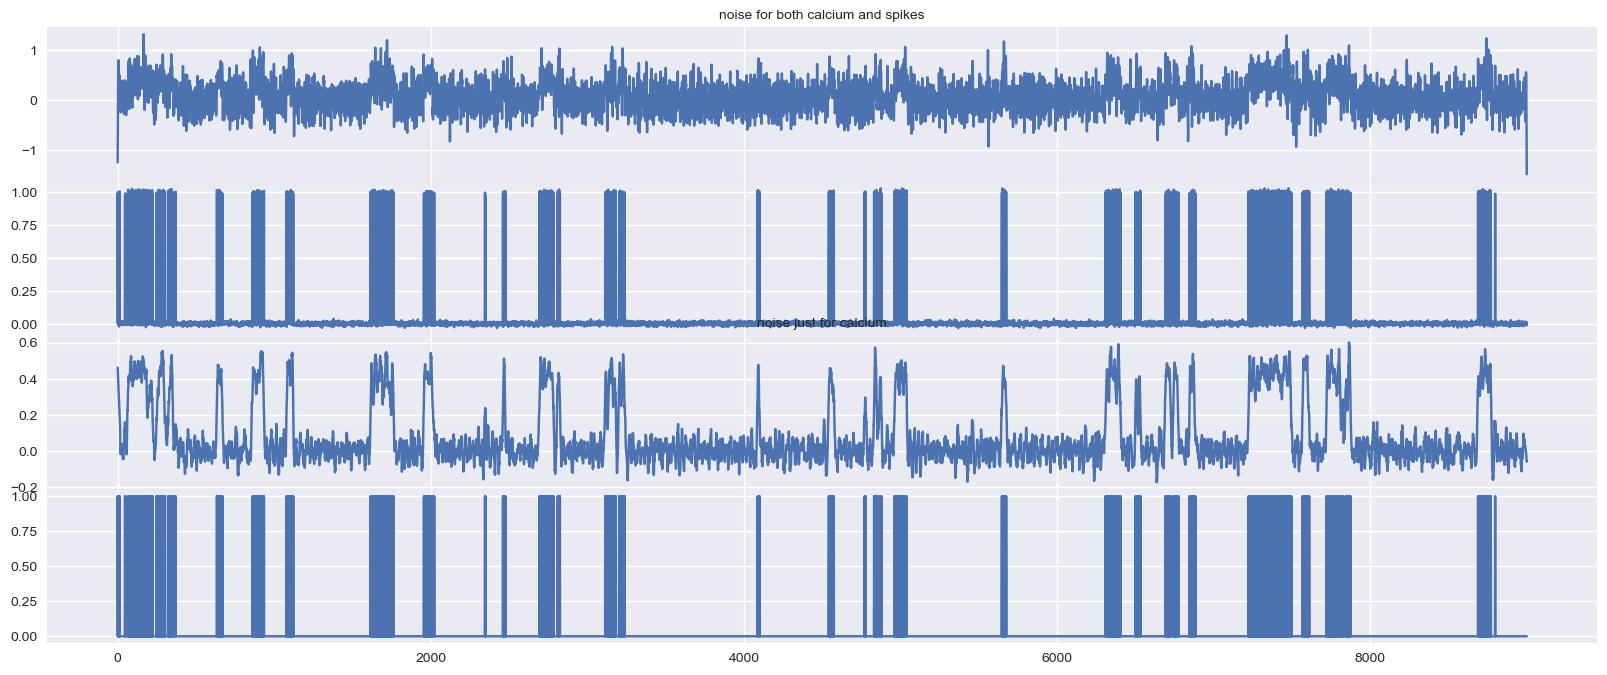

In [ ]:
f = plt.figure(figsize=(20,8))
(ax1, ax2, ax3, ax4) = f.subplots(4, sharex=True)

ax1.plot(x_ncsp)
ax1.set_title("noise for both calcium and spikes", fontsize = 10)
ax2.plot(spikes_noisy[n, :])
ax3.plot(x_nc)
ax3.set_title("noise just for calcium", fontsize = 10)
ax4.plot(spikes[n, :])

plt.subplots_adjust(hspace=0)

Following analysis shows although in denoising process some information will get lost, but the main features of signal will be preserved.

*** ---> there should be more justification for this part.***

array([ 1.0093738 , -3.48926223])

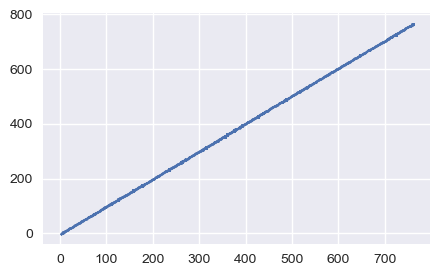

In [ ]:
cum_spikes = np.cumsum(spikes[n, :])
cum_spikes_noisy = np.cumsum(spikes_noisy[n, :])
cum_x_ncsp = np.cumsum(x_ncsp)
cum_x_nc = np.cumsum(x_nc)

fit1 = np.polyfit(cum_spikes, cum_x_ncsp, 1)
y = fit1[0]*cum_spikes + fit1[1]

f = plt.figure(figsize=(5,3))
ax = f.subplots()
ax.scatter(cum_spikes, cum_x_ncsp, s=1)
#ax.plot(cum_spikes, y)
fit1

In [ ]:
bin_size = 100
length_spike = int(np.shape(spikes)[1])
n_bins = int(np.shape(spikes)[1]/bin_size)
#dictionary of signals names 

binned_spike = np.zeros(n_bins)

c = 0
for i in range(0,n_bins):
    binned_spike[i] = np.sum(spikes[n, c:c+bin_size])
    c = c + bin_size


In [ ]:
bin_size = 100
length_xnsp = int(np.shape(x_ncsp)[0])
n_bins = int(np.shape(x_ncsp)[0]/bin_size)
#dictionary of signals names 

binned_xnsp = np.zeros(n_bins)

c = 0
for i in range(0,n_bins):
    binned_xnsp[i] = np.sum(x_ncsp[c:c+bin_size])
    c = c + bin_size


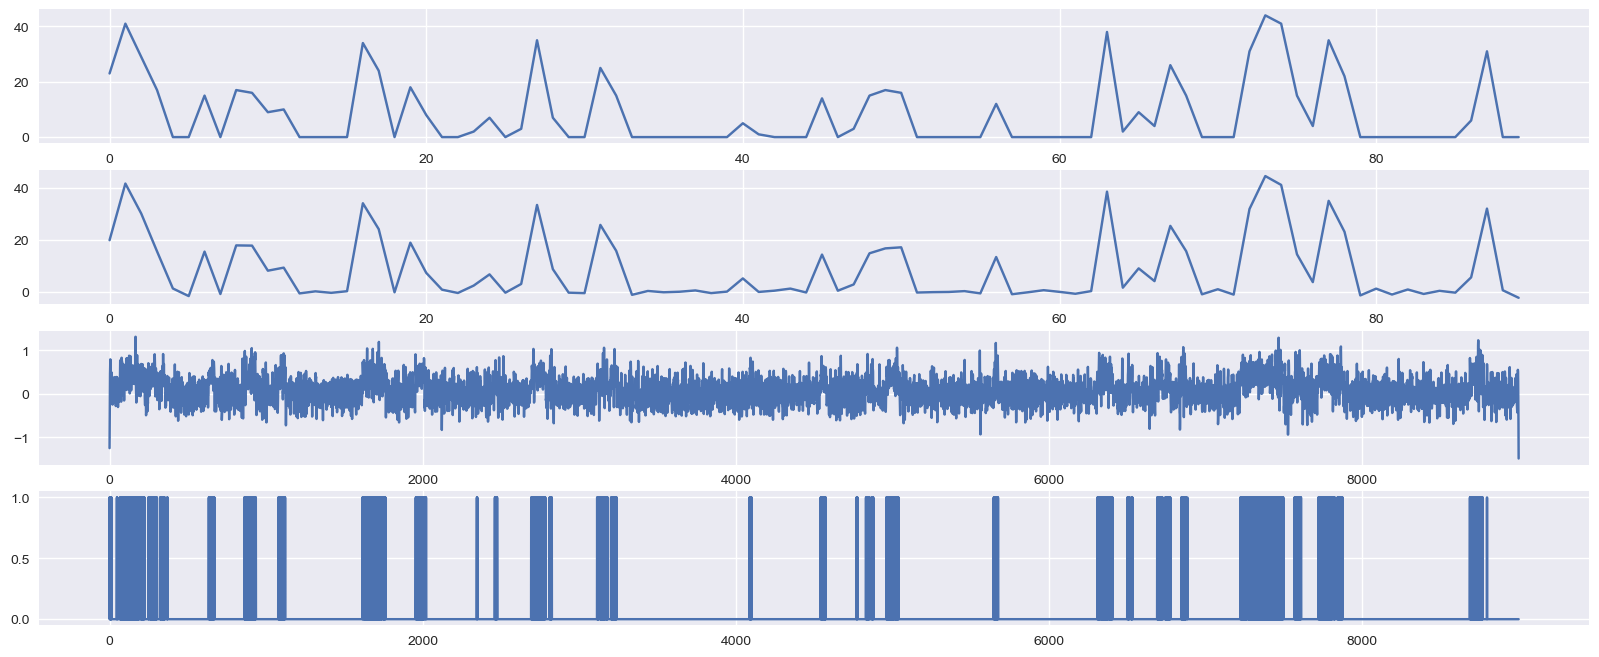

In [ ]:
f = plt.figure(figsize=(20,8))
ax1 , ax2, ax3 , ax4 = f.subplots(4)

ax1.plot(binned_spike)
ax2.plot(binned_xnsp)
ax3.plot(x_ncsp)
ax4.plot(spikes[n, :])



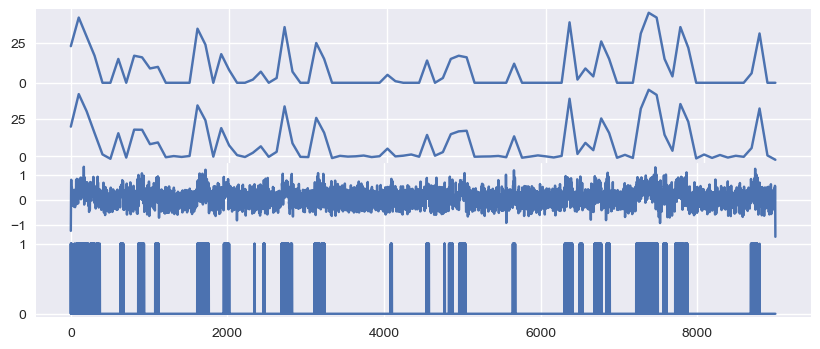

In [ ]:
f = plt.figure(figsize=(10,4))
ax1 , ax2, ax3 , ax4 = f.subplots(4)

ax1.plot(binned_spike)
ax2.plot(binned_xnsp)
ax3.plot(x_ncsp)
ax4.plot(spikes[n, :])

plt.subplots_adjust(hspace=0)

### Derivative method of time constant estimation

Process of simulation of calcium signals, denoising and taking derivatives has moved to kernel estimation functions. 
* Note that derivative has been plot 30 times bigger in order to be visible in the plot.

The idea is that for exponetial kernels, the main eq. tells the signal, its derivative and spikes and time constant are related. Finding relation between signal and derivative in periods where the "sparse" spike train is zero can give us time constant of exponential decay of calcium signal.

In [47]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.signal as sig
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

import kernel_est_funcs as kef
import conn_inf_funcs as cif
import remove_outliers as ro
import kernel_fit as kf

#plt.style.use('ggplot')
plt.style.use('seaborn')

#sns.set_style('white')

%matplotlib inline

/tmp/ipykernel_23247/3023673109.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


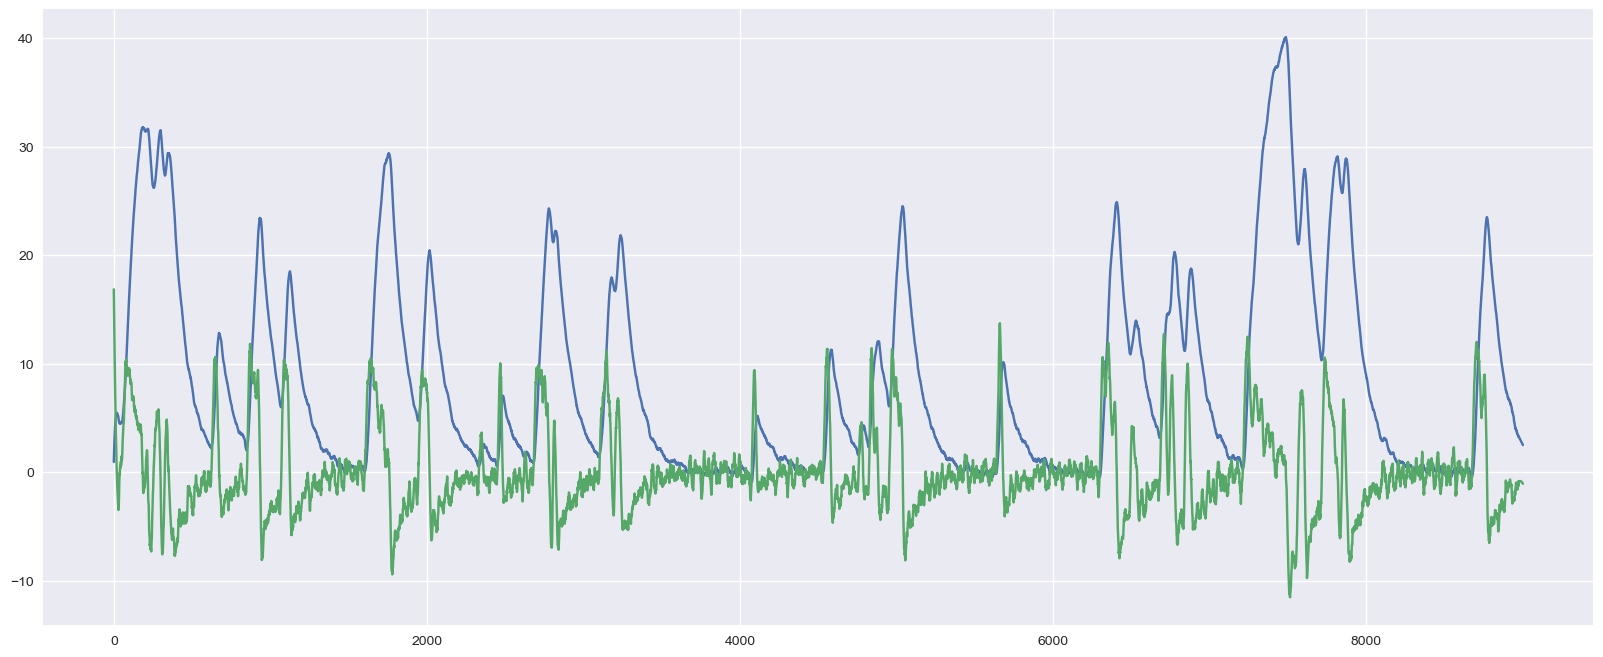

In [48]:
spikes = np.load('spikes-10e4-ms.npy')
calcium_signal, spikes = kef.sim_calcium(spikes, neuron_id=-1)
signal, deriv = kef.smoothed_signals(calcium_signal, 51, do_plots=True)

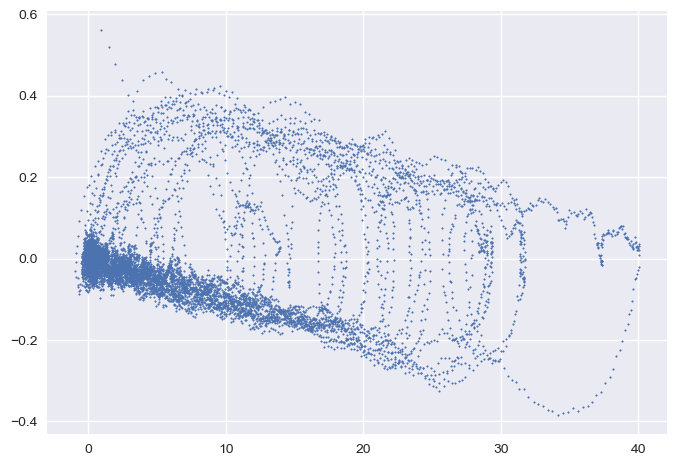

In [49]:
plt.scatter(signal[500], deriv[500], marker='.', s=5)

Out of buld data are related to periods of positive derivatives which are mostly related to spikes events. Cutting this parts will not have a huge effect on the information of signal. This process will apply to all neurons as following:

In [50]:
n_rows = np.shape(spikes)[0]

# Initialize an empty array to store the results
signal_cut = []
deriv_cut = []

# Apply the function to each row
for i in range(n_rows):
    signal_temp, deriv_temp = kef.cut_spikes(spikes[i, :], signal[i, :], deriv[i, :], win_len=5)
    signal_cut.append(signal_temp)
    deriv_cut.append(deriv_temp)

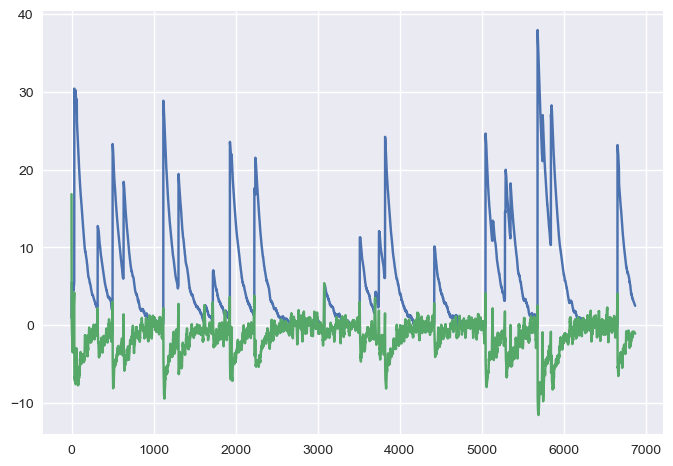

In [51]:
plt.plot(signal_cut[500])
plt.plot(30*deriv_cut[500])

106.81359895993361

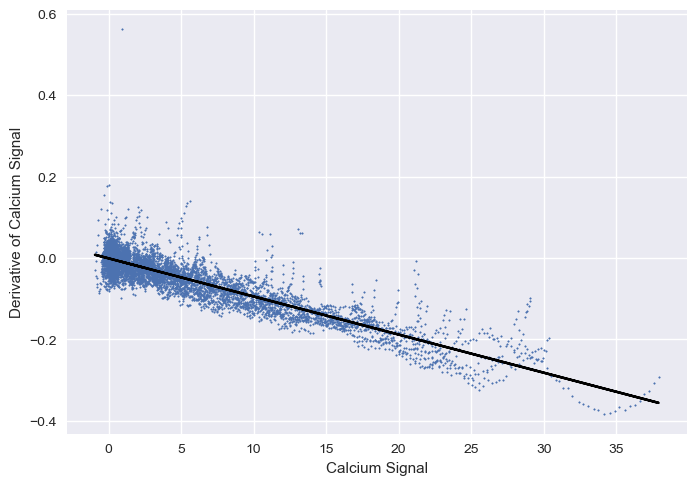

In [53]:
-1/ro.pure_fit(signal_cut[500], deriv_cut[500], do_plot=True)

103.7302166979869

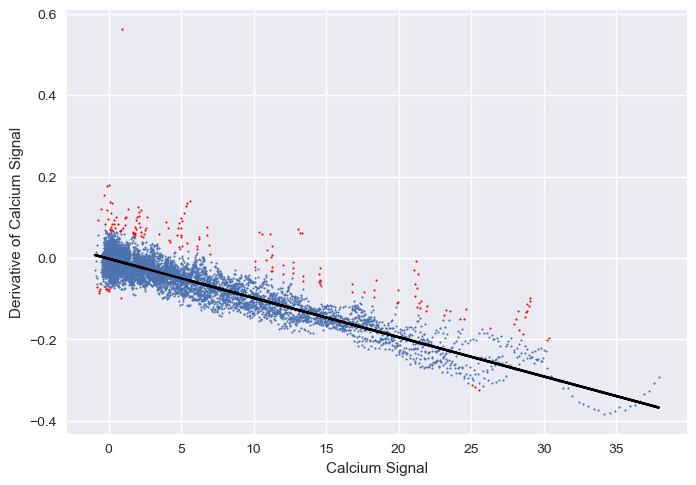

In [54]:
-1/ro.iqr_outlier(signal_cut[500], deriv_cut[500], do_plot=True)

in order to recunstruct the signal, after estimating the time constant, we can use the following eq.:

ẏ(t) + (1/tau) y(t)  =  x(t)

So the slop of the scatter plot is negative and inverse of time constant.

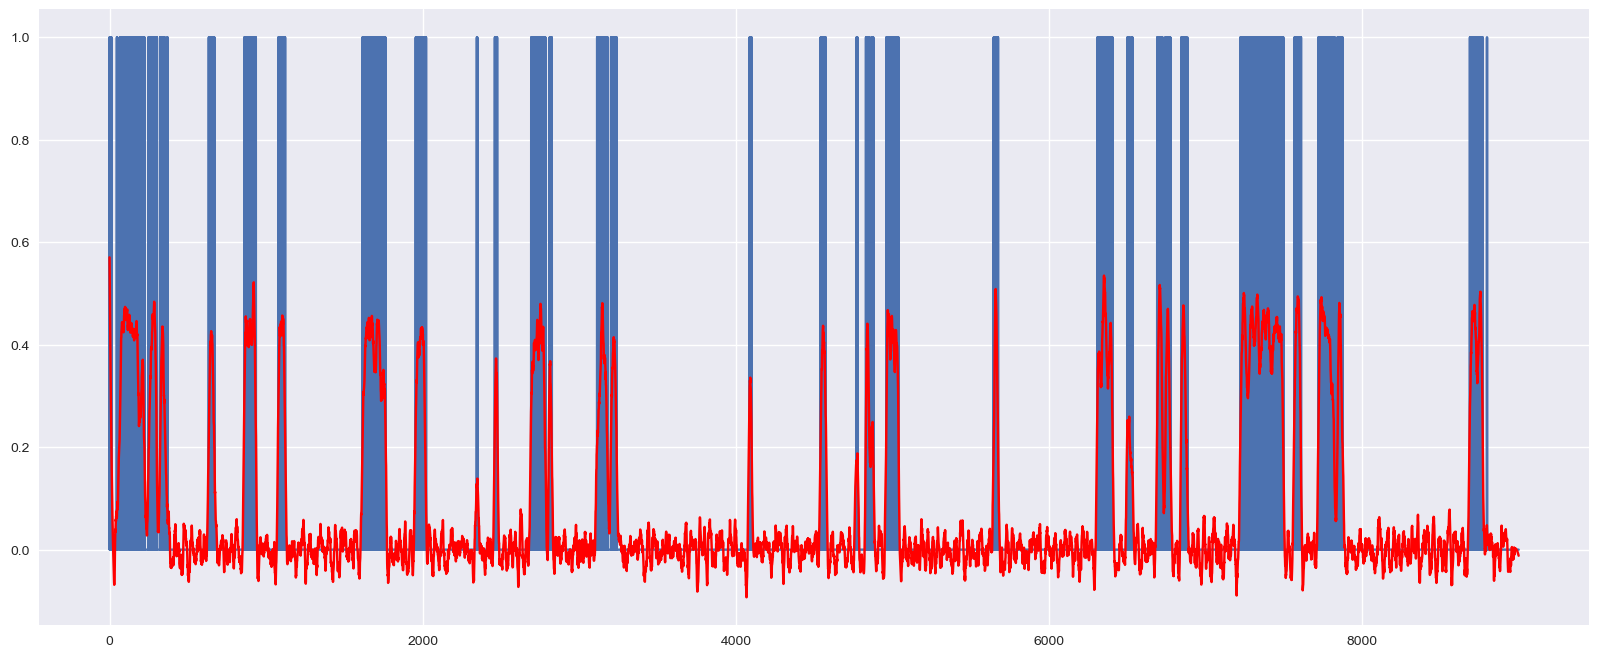

In [55]:
negative_inverse_tau = ro.iqr_outlier(signal_cut[500], deriv_cut[500])

recons_spike = deriv[500] + (-negative_inverse_tau*signal[500])

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(spikes[500, :], label='spikes')
plt.plot(recons_spike, label='reconstructed spikes', color='red')

[[1.         0.56716446]
 [0.56716446 1.        ]]
0


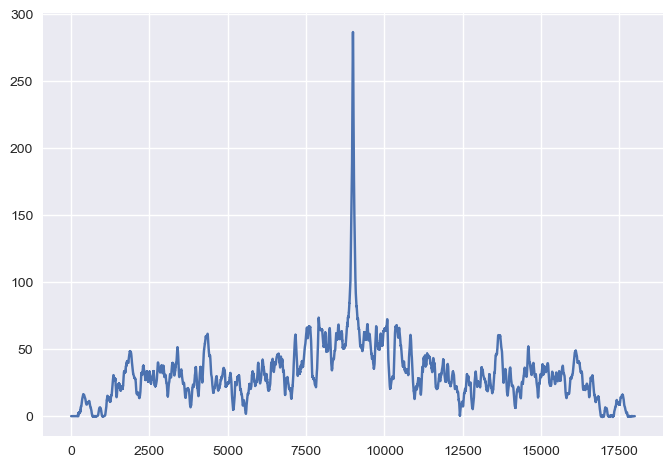

In [56]:
cross_corr = np.correlate(recons_spike, spikes[500], mode='full')
max_corr_index = np.argmax(cross_corr)
time_shift = max_corr_index - (len(spikes[500]) - 1)
print(np.corrcoef(recons_spike, spikes[500]))
print(time_shift)
plt.plot(cross_corr)

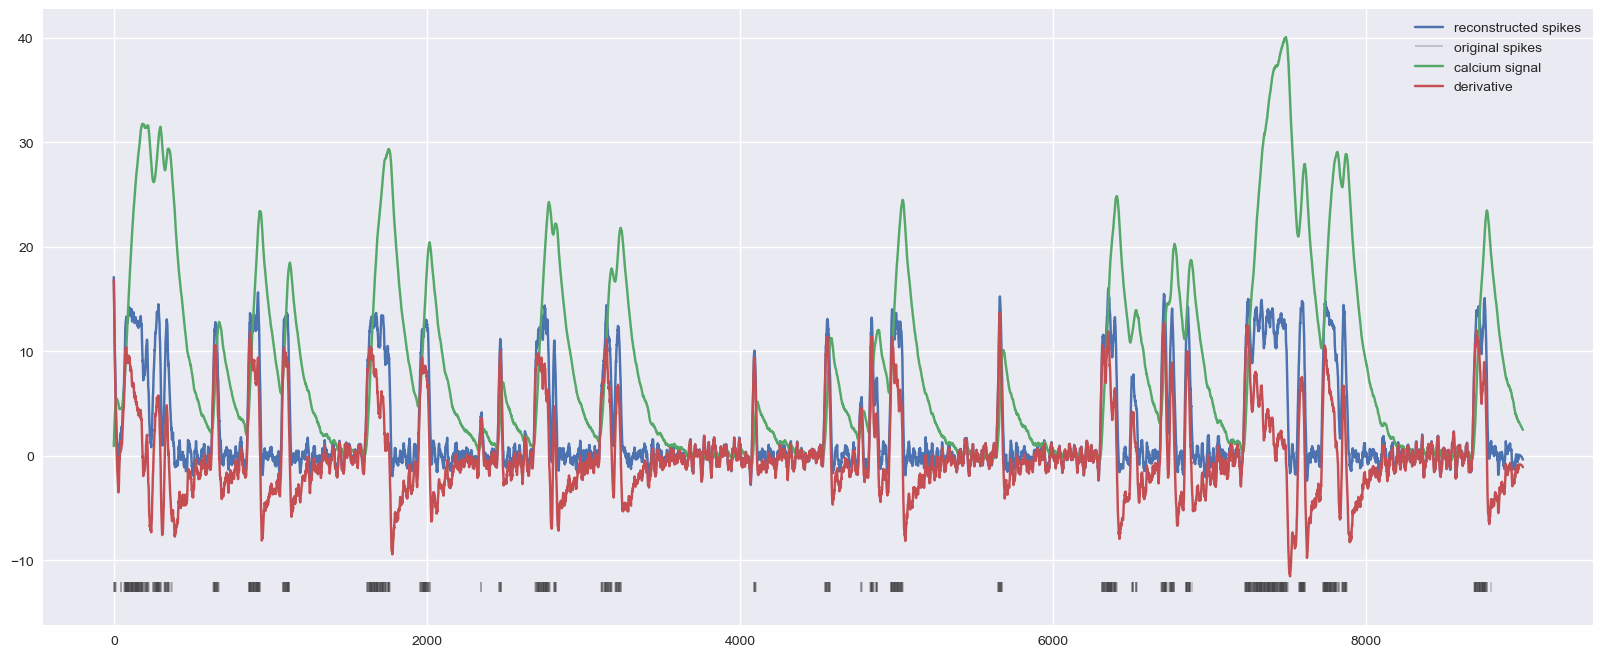

In [57]:
#%matplotlib qt
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 8))

min_dff = np.min(30*deriv[500]) - 1
ax.plot(30*recons_spike)
ax.eventplot(np.where(spikes[500, :]), lineoffsets=min_dff, linelengths=1, linewidths=0.25, color='k')
ax.plot(signal[500])
ax.plot(30*deriv[500])
ax.legend(['reconstructed spikes', 'original spikes', 'calcium signal', 'derivative'])

Test for filtering and denoising of reconstructed spikes to get a binary signal.

In [42]:
%matplotlib qt
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

original_signal = spikes[500]
reconstructed_signal = recons_spike

def create_binary_mask(original_signal, threshold=0.5):
    binary_mask = original_signal > threshold
    return binary_mask.astype(float)

def binary_mask_filter(signal, binary_mask, order=5, cutoff_freq=10.0):
    nyquist = 0.5 * len(signal)
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.copy()
    filtered_signal[~binary_mask.astype(bool)] = filtfilt(b, a, signal[~binary_mask.astype(bool)])
    return filtered_signal

# Assuming 'original_signal' and 'reconstructed_signal' are your signals as numpy arrays

# Create a binary mask based on the original signal
binary_mask = create_binary_mask(original_signal)

# Apply binary mask filter to the reconstructed signal
filtered_reconstructed_signal = binary_mask_filter(reconstructed_signal, binary_mask)

# Plot the original and filtered signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(original_signal, label='Original Signal')
plt.legend()
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label='Reconstructed Signal')
plt.plot(filtered_reconstructed_signal, label='Filtered Signal')
plt.legend()
plt.title('Reconstructed and Filtered Reconstructed Signals')

plt.tight_layout()
plt.show()


In [44]:
test = sig.savgol_filter(recons_spike, window_length=51, deriv=0, delta=1., polyorder=3)

plt.plot(recons_spike)
plt.plot(test)

In [41]:
cross_corr = np.correlate(test, spikes[500], mode='full')
max_corr_index = np.argmax(cross_corr)
time_shift = max_corr_index - (len(spikes[500]) - 1)
print(np.corrcoef(test, spikes[500]))
print(time_shift)
plt.plot(cross_corr)

[[1.         0.56412146]
 [0.56412146 1.        ]]
0


### Connectivity Inference

In order to estimate connectivity, we need alllthese process applied on all neurons. Then feed it to the multi-variate regression.

In [32]:
n_rows = np.shape(spikes)[0]

tau_est = np.empty(n_rows)
for i in range(n_rows):
    tau_est[i] = ro.pure_fit(signal_cut[i], deriv_cut[i], do_plot=False)

In [33]:
feed_signals = np.empty((n_rows, np.shape(spikes)[1]))
for i in range(n_rows):
    feed_signals[i] = cif.reconstructed_spikes(signal[i], deriv[i], tau_est[i])

In [34]:
cif.conn_inf_LR('connectivity-10e4-ms.npy', feed_signals)

0.1277147860619256

In [35]:
cif.conn_inf_LR('connectivity-10e4-ms.npy', spikes)

0.12164516899975328

In [36]:
cif.conn_inf_LR('connectivity-10e4-ms.npy', signal)

0.12553799627162868

### should be cleaned

In [ ]:
noiseN = np.random.normal(0,1, (N, sim_dur))
noisy_cal = calcium + noiseN

#np.save('noisy_cal_10e4', noisy_cal)

In [ ]:
smooth_cal = sig.savgol_filter(noisy_cal, window_length=31, deriv=0, delta=1., polyorder=5)
smooth_deriv = sig.savgol_filter(noisy_cal, window_length=31, deriv=1, delta=1., polyorder=5)

#denoised noisy_calcium which is going to inferene procedure
signal = smooth_deriv + (1/tau)*smooth_cal

np.corrcoef(spikes.flatten(), signal.flatten())[0, 1]

In [ ]:
#plt.figure()
plt.subplot(2,1,1)
plt.plot(signal[500, 1:8900])
plt.subplot(2,1,2)
plt.plot(spikes[500, 1:8900])

In [ ]:
plt.plot(signal[500, 4000:5000], spikes[500, 4000:5000], '.')

In [ ]:

G = np.load('connectivity-10e5-ms.npy')
G = G - (np.diag(np.diag(G)))

In [ ]:
k = 10
Y = signal[:, k:]
Y_prime = signal[:, :-k]

yk = Y.T
y_k = Y_prime.T

np.shape(yk)

In [ ]:
reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

In [ ]:
k = 10
Y = spikes[:, k:]
Y_prime = spikes[:, :-k]

yk = Y.T
y_k = Y_prime.T


reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

In [ ]:
k = 10
Y = calcium[:, k:]
Y_prime = calcium[:, :-k]

yk = Y.T
y_k = Y_prime.T


reg = LinearRegression(n_jobs=-1).fit(y_k, yk)
a = reg.coef_
a = a - (np.diag(np.diag(a)))
np.corrcoef(G.flatten(), a.flatten())[0, 1]

### Kernel fitting

In [ ]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]

noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
spikes_noisy = spikes + noise_intra

calcium = np.zeros((N, sim_dur))
calcium_nsp = np.zeros((N, sim_dur))
tau = 100
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]
calcium_nsp[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]


for t in range(1, sim_dur):
    calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]


In [ ]:
n = 500
#calciumN = calcium[n, :]
noise_recording = np.random.normal(0,1, (N, sim_dur))
calcium_noisy = calcium + noise_recording

#calciumN_nsp = calcium_nsp[n, :]
#noise = np.random.normal(0,1, sim_dur)
calcium_nsp_noisy = calcium_nsp + noise_recording

In [ ]:
smooth_cal = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=11, deriv=1, delta=1., polyorder=3)

x_ncsp = smooth_deriv + (1/tau)*smooth_cal

In [ ]:
f = plt.figure(figsize=(20,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

# ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

In [ ]:
from scipy.optimize import curve_fit

def func(t_test, A_test, tau_test):
    return A_test * np.exp(-t_test/tau_test)

In [ ]:
c_test1 = calcium_nsp_noisy[n, 5500:6200]
sav_test1 = smooth_cal[5500:6200]
savd_test1 = smooth_deriv[5500:6200]

plt.plot(c_test1)

np.where(c_test1 == np.max(c_test1))[0]

In [ ]:
sav_test1 = sav_test1[179:]
savd_test1 = savd_test1[179:]

In [ ]:
len(sav_test1)

In [ ]:
x1 = np.arange(0,521, 1)
c_test1 = c_test1[179:]


popt, pcov = curve_fit(func, x1, c_test1)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x1, c_test1, 'bo', label='Data')
plt.plot(x1, func(x1, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

In [ ]:
popt

In [ ]:
c_test2 = calcium_nsp_noisy[n, 1000:1600]

plt.plot(c_test2)

np.where(c_test2 == np.max(c_test2))[0]

In [ ]:
sav_test1 = sav_test1[179:]
savd_test1 = savd_test1[179:]

In [ ]:
x2 = np.arange(0,478, 1)
c_test2 = c_test2[122:]
popt, pcov = curve_fit(func, x2, c_test2)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x2, c_test2, 'bo', label='Data')
plt.plot(x2, func(x2, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

In [ ]:
c_test3 = calcium_nsp_noisy[n, 350:600]

plt.plot(c_test3)

np.where(c_test3 == np.min(c_test3))[0]

In [ ]:
x3 = np.arange(0,250, 1)
#c_test2 = c_test2[122:]
popt, pcov = curve_fit(func, x3, c_test3)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x3, c_test3, 'bo', label='Data')
plt.plot(x3, func(x3, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

In [ ]:
aucor = np.correlate(calcium_nsp_noisy[n, :], calcium_nsp_noisy[n,:], mode='full')

aucor /= np.max(aucor)

h_aucor = aucor[int(len(aucor)/2):]
h_aucor = h_aucor[50:200]

#plt.plot(h_aucor)

In [ ]:
#x_aucor = np.arange(0,int(len(aucor)/2)+1, 1)
x_aucor = np.arange(0,int(len(h_aucor)), 1)
popt, pcov = curve_fit(func, x_aucor, h_aucor)

# Extract the fitted parameters
A_fit, tau_fit = popt

# Plot the original data and the fitted curve
plt.plot(x_aucor, h_aucor, 'bo', label='Data')
plt.plot(x_aucor, func(x_aucor, A_fit, tau_fit), 'r-', label='Fit')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print the estimated time constant
print('Time constant: ', tau_fit)

(1250, 9000)

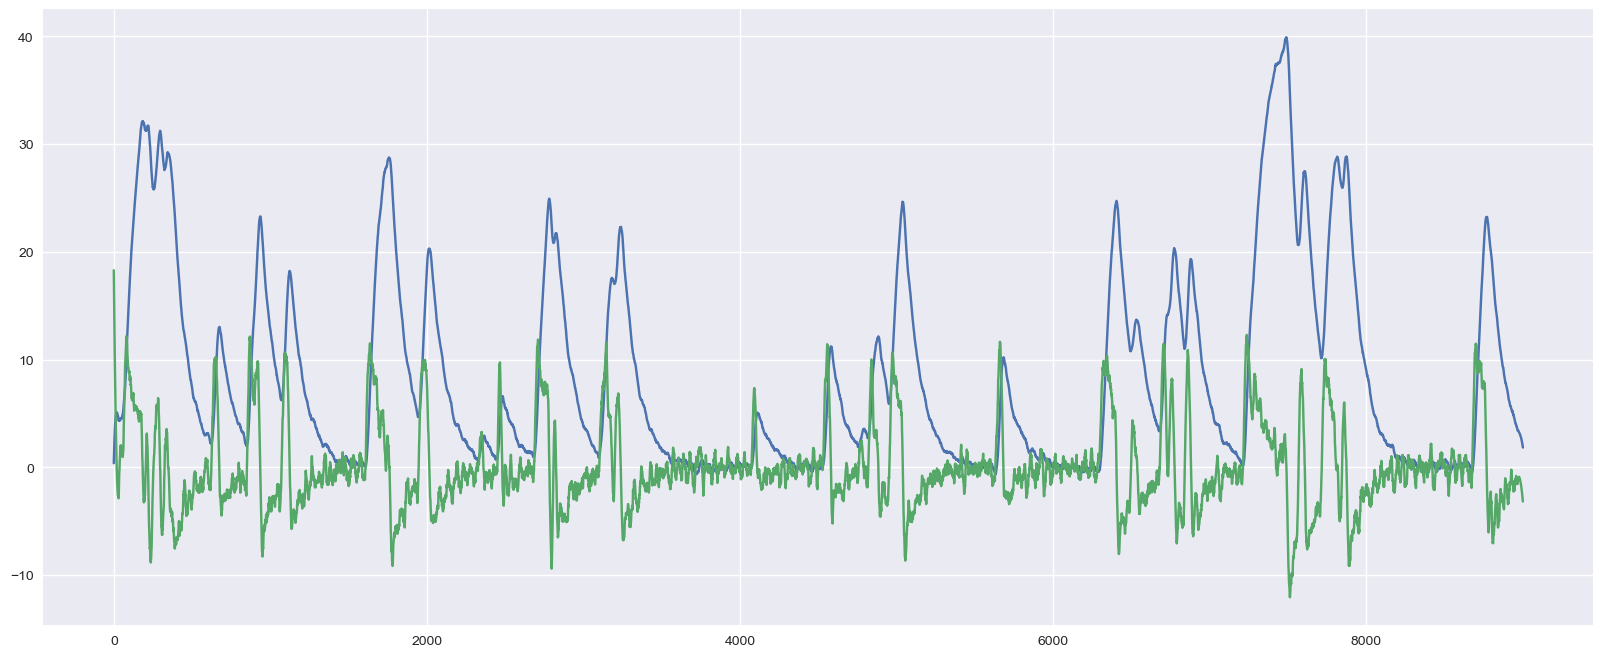

In [1]:
import numpy as np
import kernel_est_funcs as kef
import scipy.signal as sig
import matplotlib.pyplot as plt

spikes = np.load('spikes-10e4-ms.npy')

calcium_signal, spikes = kef.sim_calcium(spikes, neuron_id=-1)

signal, deriv = kef.smoothed_signals(calcium_signal, 51, do_plots=True)

calcium_signal.shape


#cut_signal, cut_deriv = kef.cut_spikes(spikes, signal, deriv)

In [2]:
n_rows = np.shape(spikes)[0]

# Initialize an empty array to store the results
signal_cut = []
deriv_cut = []

# Apply the function to each row
for i in range(n_rows):
    signal_temp, deriv_temp = kef.cut_spikes(spikes[i, :], signal[i, :], deriv[i, :], win_len=5)
    signal_cut.append(signal_temp)
    deriv_cut.append(deriv_temp)

-0.009411986749611544

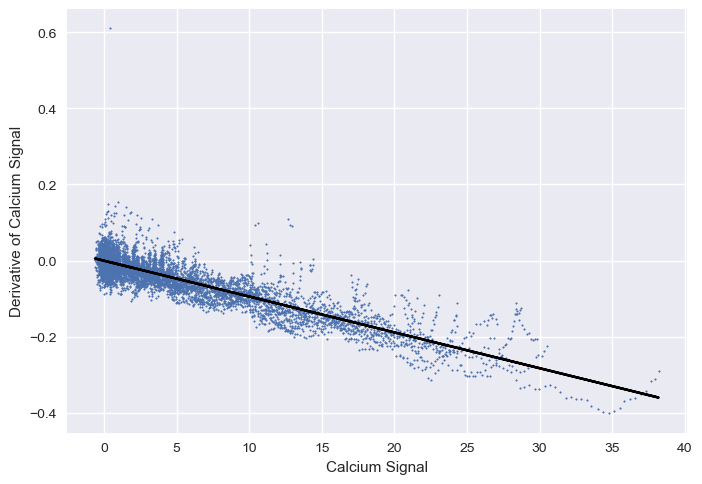

In [3]:
kef.pure_fit(signal_cut[500], deriv_cut[500], do_plot=True)

-0.009826866337799382

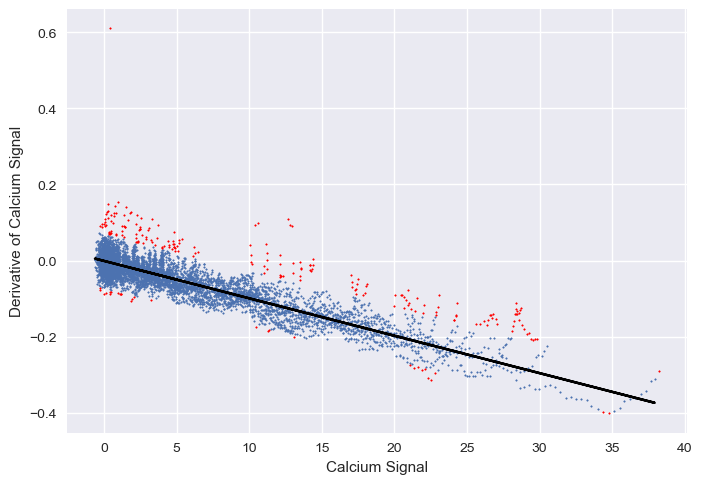

In [4]:
kef.iqr_outlier(signal_cut[500], deriv_cut[500], do_plot=True)

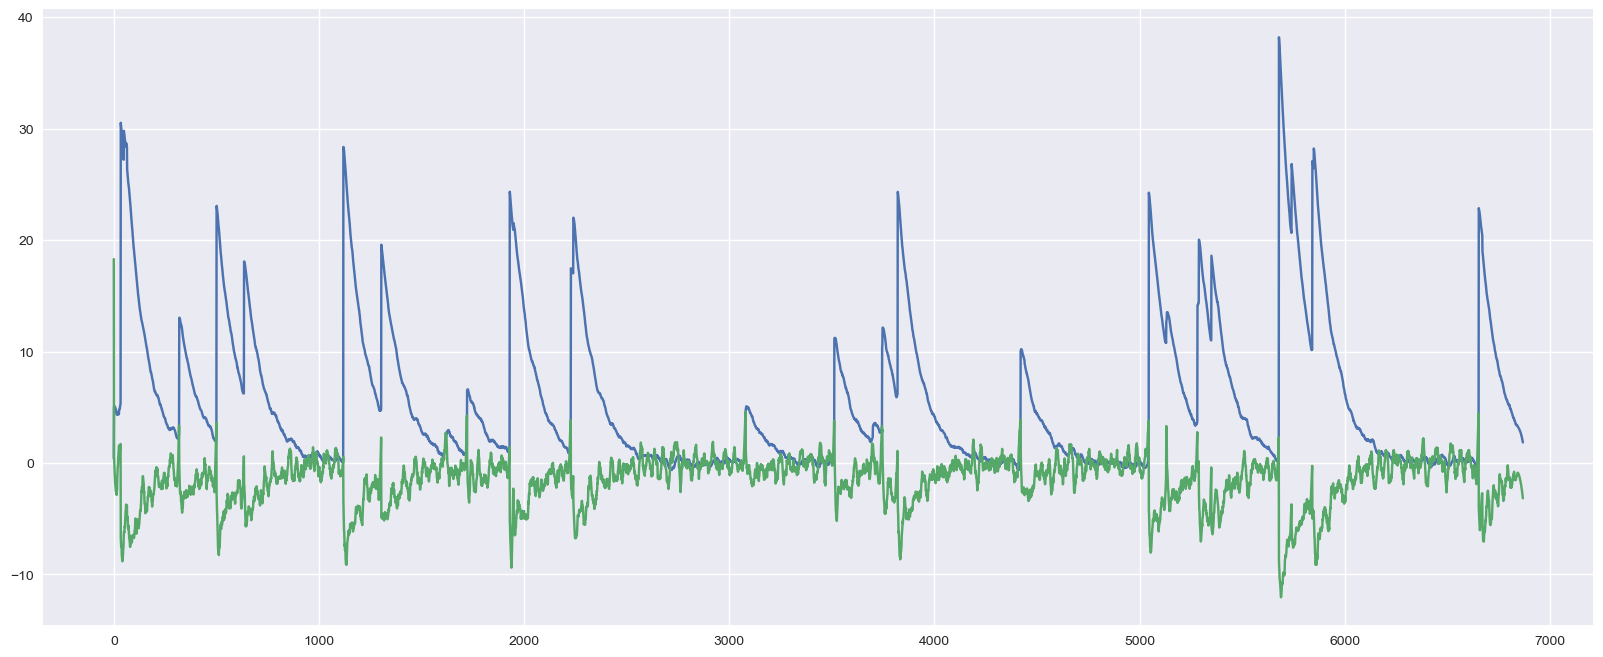

In [5]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(signal_cut[500])
ax.plot(30*deriv_cut[500])

In [6]:
import conn_inf_funcs as cif
import remove_outliers as ro
n_rows = np.shape(spikes)[0]

tau_est = np.empty(n_rows)
for i in range(n_rows):
    tau_est[i] = ro.pure_fit(signal_cut[i], deriv_cut[i], do_plot=False)

In [7]:
feed_signals = np.empty((n_rows, np.shape(spikes)[1]))
for i in range(n_rows):
    feed_signals[i] = cif.reconstructed_spikes(signal[i], deriv[i], tau_est[i])

[[1.         0.56587735]
 [0.56587735 1.        ]]
0


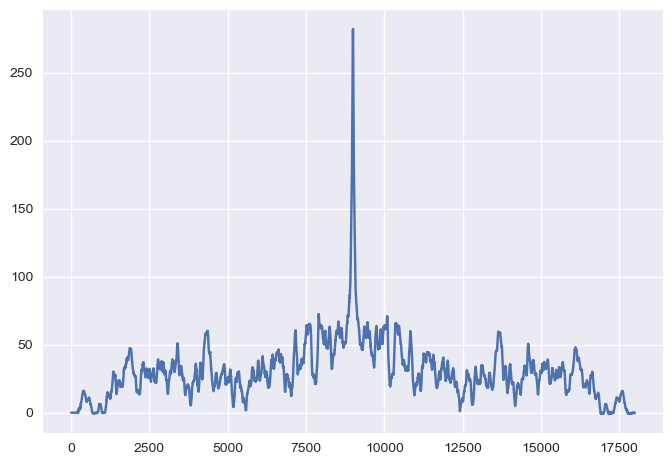

In [8]:
cross_corr = np.correlate(feed_signals[500], spikes[500], mode='full')
max_corr_index = np.argmax(cross_corr)
time_shift = max_corr_index - (len(spikes[500]) - 1)
print(np.corrcoef(feed_signals[500], spikes[500]))
print(time_shift)
plt.plot(cross_corr)

In [26]:
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

# Assuming 'original_signal' and 'reconstructed_signal' are your signals as numpy arrays

original_signal = spikes[500]
reconstructed_signal = feed_signals[500]

# Define filter parameters
order = 5  # Filter order
cutoff_freq = 10.0  # Cutoff frequency in Hz

# Normalize the cutoff frequency by the Nyquist frequency
nyquist = 0.5 * len(original_signal)  # Nyquist frequency is half of the sample rate
normal_cutoff = cutoff_freq / nyquist

# Design Butterworth low-pass filter
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# Apply the filter to both signals
filtered_original_signal = lfilter(b, a, original_signal)
filtered_reconstructed_signal = lfilter(b, a, reconstructed_signal)

# Plot the original and filtered signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(original_signal, label='Original Signal')
plt.plot(filtered_original_signal, label='Filtered Signal')
plt.legend()
plt.title('Original and Filtered Original Signals')

plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label='Reconstructed Signal')
plt.plot(filtered_reconstructed_signal, label='Filtered Signal')
plt.legend()
plt.title('Reconstructed and Filtered Reconstructed Signals')

plt.tight_layout()
plt.show()


In [37]:
%matplotlib qt
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

def create_binary_mask(original_signal, threshold=0.5):
    binary_mask = original_signal > threshold
    return binary_mask.astype(float)

def binary_mask_filter(signal, binary_mask, order=5, cutoff_freq=10.0):
    nyquist = 0.5 * len(signal)
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.copy()
    filtered_signal[~binary_mask.astype(bool)] = filtfilt(b, a, signal[~binary_mask.astype(bool)])
    return filtered_signal

# Assuming 'original_signal' and 'reconstructed_signal' are your signals as numpy arrays

# Create a binary mask based on the original signal
binary_mask = create_binary_mask(original_signal)

# Apply binary mask filter to the reconstructed signal
filtered_reconstructed_signal = binary_mask_filter(reconstructed_signal, binary_mask)

# Plot the original and filtered signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(original_signal, label='Original Signal')
plt.legend()
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal, label='Reconstructed Signal')
plt.plot(filtered_reconstructed_signal, label='Filtered Signal')
plt.legend()
plt.title('Reconstructed and Filtered Reconstructed Signals')

plt.tight_layout()
plt.show()


In [27]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

def highpass_filter(signal, cutoff_freq, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Assuming 'original_signal' and 'reconstructed_signal' are your signals as numpy arrays

# Define cutoff frequency for high-pass filter
cutoff_freq = 10.0  # Adjust this as needed

# Apply high-pass filter to the reconstructed signal
h_filtered_reconstructed_signal = highpass_filter(filtered_reconstructed_signal, cutoff_freq, fs)

# Plot the original and filtered signals
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(original_signal, label='Original Signal')
plt.legend()
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(filtered_reconstructed_signal, label='Reconstructed Signal')
plt.plot(h_filtered_reconstructed_signal, label='Filtered Signal')
plt.legend()
plt.title('Reconstructed and Filtered Reconstructed Signals')

plt.tight_layout()
plt.show()


NameError: name 'fs' is not defined

In [18]:
test = h_filtered_reconstructed_signal.copy()
test[abs(test) < 0.05] = 0

plt.figure(2)
plt.plot(h_filtered_reconstructed_signal, label='Filtered Signal')
plt.plot(test, label='Reconstructed Signal')

NameError: name 'h_filtered_reconstructed_signal' is not defined

In [ ]:
test2 = test.copy()
test2[test2 != 0] = 1

In [ ]:
np.corrcoef(test2, original_signal)

array([[1.        , 0.54253147],
       [0.54253147, 1.        ]])

In [ ]:
plt.figure(1,figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(original_signal, label='Original Signal')
plt.legend()
plt.title('Original Signal')

plt.subplot(2, 1, 2)
plt.plot(filtered_reconstructed_signal, label='Reconstructed Signal')
plt.plot(test2, label='Filtered Signal')
plt.legend()
plt.title('Reconstructed and Filtered Reconstructed Signals')

plt.tight_layout()
plt.show()


In [ ]:
test2[:100]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.])

In [ ]:
test[:100]

array([ 0.        ,  0.06664005, -0.09296884,  0.06398827,  0.06150534,
       -0.21568239,  0.05928618, -0.2901485 ,  0.05736768,  0.05525815,
       -0.39047027,  0.05380275, -0.44955859,  0.05266172,  0.05094294,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.50928922,  0.        , -0.50697415,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.26322652,  0.        , -0.22

In [ ]:
test1 = h_filtered_reconstructed_signal.copy()
test1[abs(test1) < 0.05] = 0
test1[:100]

array([ 0.        ,  0.06664005, -0.09296884,  0.06398827,  0.06150534,
       -0.21568239,  0.05928618, -0.2901485 ,  0.05736768,  0.05525815,
       -0.39047027,  0.05380275, -0.44955859,  0.05266172,  0.05094294,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.50928922,  0.        , -0.50697415,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.26322652,  0.        , -0.22

In [ ]:
original_signal[:100]

array([1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])

In [ ]:
print(np.count_nonzero(test2))
print(np.count_nonzero(original_signal))
print(np.count_nonzero(test))

1797
761
1797


In [29]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(20, 8))

min_dff = np.min(30*deriv[500]) - 1
ax.plot(30*feed_signals[500])
ax.eventplot(np.where(spikes[500, :]), lineoffsets=min_dff, linelengths=1, linewidths=0.25, color='k')
ax.plot(signal[500])
ax.plot(30*deriv[500])
ax.legend(['reconstructed spikes', 'original spikes', 'calcium signal', 'derivative'])

In [ ]:
import conn_inf_funcs as cif

cif.conn_inf_LR('connectivity-10e4-ms.npy', test)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
cif.conn_inf_LR('connectivity-10e4-ms.npy', spikes)

0.12164516899975328

### Derivative method for finding time constant

*** intuitively and by analysis of cut part of the signal in lower blocks we can see the derivative is positive after spikes when the signal is rising. except this part, signal and its derivative can be considered and their own coeficient(we can confirm it by looking at plots of signal and derivative). now by cutting the positive parts of derivative, we can find the coeffiecent as slop of scatter plot, which is the time constant.

In [ ]:
import kernel_est_funcs as kef
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
signal_cut_neg = signal[deriv<0]
deriv_cut_neg = deriv[deriv<0]

In [ ]:
%matplotlib qt

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(signal_cut_neg)
ax1.plot(30*deriv_cut_neg)
ax2.plot(signal)
ax2.plot(30*deriv)

 ...]

: 

In [ ]:
#%matplotlib inline
kef.pure_fit(signal_cut_neg, deriv_cut_neg, do_plot=True)

In [ ]:
cum_signal = np.cumsum(signal)
cum_spikes = np.cumsum(spikes)

slop = np.polyfit(cum_spikes, cum_signal, deg=1)

plt.scatter(cum_spikes, cum_signal)

slop

In [ ]:
signal_cut, deriv_cut = kef.cut_spikes(spikes, signal, deriv)

In [ ]:
len(signal)

In [ ]:
np.count_nonzero(spikes)

In [ ]:
%matplotlib qt

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(signal_cut)
ax1.plot(30*deriv_cut)
ax2.plot(signal)
ax2.plot(30*deriv)

In [ ]:
%matplotlib inline
kef.iqr_outlier(signal_cut, deriv_cut, do_plot=True)

In [ ]:
%matplotlib inline
kef.pure_fit(signal_cut, deriv_cut, do_plot=True)

In [ ]:
%matplotlib inline
kef.iqr_outlier(signal, deriv, do_plot=True)

In [ ]:
100000/97

test whith assymmetric iqr and possitive signal.

In [ ]:
kef.iqr_outlier(signal, deriv, percentile_start=5, percentile_end=55, do_plot=True)

In [ ]:
1000000/912

test assymetric iqr with negative signal

In [ ]:
signal, deriv = kef.smoothed_signals(calcium_signal, savgol_win, neg=True, do_plots=False)
kef.iqr_outlier(signal, deriv, percentile_start=5, percentile_end=55, do_plot=True)

In [ ]:
1000000/948

symmetric-positive

In [ ]:
signal, deriv = kef.smoothed_signals(calcium_signal, savgol_win, do_plots=False)
kef.iqr_outlier(signal, deriv, percentile_start=25, percentile_end=75, do_plot=True)

In [ ]:
100000/87

In [ ]:
signal, deriv = kef.smoothed_signals(calcium_signal, savgol_win, neg=True, do_plots=False)
kef.iqr_outlier(signal, deriv, percentile_start=25, percentile_end=75, do_plot=True)

In [ ]:
100000/95

This part is for testing derivitive outlier removal in cutting window at spike occurrence.

following are some preliminary analysis which may be helpful in future as a draft.

signal and its derivative smothed by sav-gol filter

In [ ]:
spikes = np.load("spikes-10e4-ms.npy")

N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]

noise_intra = np.random.normal(0, 0.01, (N, sim_dur))
spikes_noisy = spikes + noise_intra

calcium = np.zeros((N, sim_dur))
calcium_nsp = np.zeros((N, sim_dur))
tau = 100
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]
calcium_nsp[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]


for t in range(1, sim_dur):
    calcium_nsp[:, t] = const_A*calcium_nsp[:, t-1] + spikes_noisy[:, t]


In [ ]:
n = 500
#calciumN = calcium[n, :]
noise_recording = np.random.normal(0,1, (N, sim_dur))
calcium_noisy = calcium + noise_recording

#calciumN_nsp = calcium_nsp[n, :]
#noise = np.random.normal(0,1, sim_dur)
calcium_nsp_noisy = calcium_nsp + noise_recording

In [ ]:
f = plt.figure(figsize=(20,2)) #figure size inside
#ax1 = f.add_axes() #axis limits inside when there is no subplots
#ax1 = plt.subplot(2,1,1) when you want to share axes between subplots you don't use this
ax2 = f.subplots(1)

ax2.set_title('spikes + noise -> calcium + noise')
ax2.plot(calcium_nsp_noisy[n, :], label = 'calcium+noise')
ax2.plot(noise_recording[n, :], label = 'noise')
ax2.plot(calcium_nsp[n, :], label = 'calcium')
ax2.plot(spikes_noisy[n, :], label = 'spike')
ax2.legend()

In [ ]:
smooth_cal = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=51, deriv=0, delta=1., polyorder=3)
smooth_deriv = sig.savgol_filter(calcium_nsp_noisy[n, :], window_length=51, deriv=1, delta=1., polyorder=3)

x_ncsp = smooth_deriv + (1/tau)*smooth_cal

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(smooth_cal)
plt.plot(30*smooth_deriv)

In [ ]:
neg_smooth_cal = smooth_cal[smooth_deriv < 0]
neg_smooth_deriv = smooth_deriv[smooth_deriv < 0]

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(neg_smooth_cal)
plt.plot(30*neg_smooth_deriv)

In [ ]:
def remove_outliers(x, y, threshold=.05):
    x = np.array(x)
    y = np.array(y)
    residuals = y - np.polyval(np.polyfit(x, y, 1), x)
    quartile_1, quartile_3 = np.percentile(residuals, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (threshold * iqr)
    upper_bound = quartile_3 + (threshold * iqr)
    mask = (residuals >= lower_bound) & (residuals <= upper_bound)
    return x[mask], y[mask]

#x, y = remove_outliers(x, y)

In [ ]:
b, a = np.polyfit(smooth_cal, smooth_deriv, deg=1)
b

In [ ]:
fig, ax = plt.subplots()
ax.scatter(smooth_cal, smooth_deriv, marker='.', s=5)
ax.plot(smooth_cal, a+b*smooth_cal, color='k')

In [ ]:
plt.scatter(smooth_cal, smooth_deriv, marker='.', s=5)
plt.plot(smooth_cal, a+b*smooth_cal, color='k')

In [ ]:
from scipy import stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(smooth_cal, smooth_deriv)

print("Slope:", slope)
print("Intercept:", intercept)


In [ ]:
x_out, y_out = remove_outliers(smooth_cal, smooth_deriv, threshold=.5)
b_out, a_out = np.polyfit(x_out, y_out, deg=1)
b_out

In [ ]:
plt.scatter(x_out, y_out, marker='o',s=5)
plt.plot(x_out, a_out+b_out*x_out, color = 'k')

In [ ]:
b_neg, a_neg = np.polyfit(neg_smooth_cal, neg_smooth_deriv, deg=1)
b_neg

In [ ]:
plt.scatter(neg_smooth_cal, neg_smooth_deriv, marker='o', s=5)
plt.plot(neg_smooth_cal, a_neg+b_neg*neg_smooth_cal, color='k')

In [ ]:
x_neg_out, y_neg_out = remove_outliers(neg_smooth_cal, neg_smooth_deriv, threshold=1.5)
b, a = np.polyfit(x_neg_out, y_neg_out, deg=1)
b

In [ ]:
plt.scatter(x_neg_out, y_neg_out, marker='o', s=5)
plt.plot(x_neg_out, a+b*x_neg_out, color ='k')

In [ ]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor()
x = np.array(neg_smooth_cal).reshape(-1, 1)
y = np.array(neg_smooth_deriv)
ransac.fit(x, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_x = np.linspace(min(x), max(x), 100).reshape(-1, 1)
line_y = ransac.predict(line_x)

In [ ]:
plt.scatter(x[inlier_mask], y[inlier_mask], label='Inliers', marker='o', s=5)
plt.scatter(x[outlier_mask], y[outlier_mask], label='Outliers', color='red', marker='o', s=5)
plt.plot(line_x, line_y, color='green', label='Robust Regression Line')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [ ]:
ransac.estimator_.coef_[0]

In [ ]:
sav_test1 = smooth_cal[4900:5600]
savd_test1 = 50*smooth_deriv[4900:5600]
plt.figure(figsize=(20, 5))
plt.plot(sav_test1)
plt.plot(savd_test1)

### single spike test

In [ ]:
spikes11 = np.zeros((100, 1))
spikes11[50, 0] = 1

N11 = np.shape(spikes11)[1]
sim_dur11 = np.shape(spikes11)[0]

noise_intra11 = np.random.normal(0, 0.01, (N11, sim_dur11))
spikes_noisy11 = spikes11 + noise_intra11

calcium11 = np.zeros((N11, sim_dur11))
calcium_nsp11 = np.zeros((N11, sim_dur11))
tau11 = 100
dt11 = 1
const_A11 = np.exp((-1/tau11)*dt11)

calcium11[:, 0] = spikes11[:, 0]
calcium_nsp11[:, 0] = spikes11[:, 0]

for t in range(1, sim_dur11):
    calcium11[:, t] = const_A11*calcium11[:, t-1] + spikes11[:, t]


for t in range(1, sim_dur11):
    calcium_nsp11[:, t] = const_A11*calcium_nsp11[:, t-1] + spikes_noisy11[:, t]

In [ ]:
spike11 = np.zeros(100)
spikes11[50] = 1

calcium11 = np.zeros(100)
calcium_nsp11 = np.zeros(100)

noise_intra11 = np.random.normal(0, 0.01, 100)
spikes_noisy11 = spikes11 + noise_intra11

tau11 = 100
dt11 = 1
const_A11 = np.exp((-1/tau11)*dt11)

for t in range(1, 100):
    calcium11[t] = const_A11*calcium11[t-1] + spikes11[t]

'''
for t in range(1, 100):
    calcium_nsp11[t] = const_A11*calcium_nsp11[t-1] + spikes_noisy11[t]
'''

In [ ]:
noise_intra11 = np.random.normal(0, 0.01, 100)
np.shape(noise_intra11)
np.shape(spike11)

In [ ]:
spike11[50]

In [ ]:
plt.figure()
plt.plot(spikes11)
plt.plot(calcium11)

In [ ]:
smooth_cal11 = sig.savgol_filter(calcium11, window_length=31, deriv=0, delta=1., polyorder=3)
smooth_deriv11 = sig.savgol_filter(calcium11, window_length=31, deriv=1, delta=1., polyorder=3)

x_nc11 = smooth_deriv11 + (1/tau)*smooth_cal11

In [ ]:
plt.plot(x_nc11)